In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './CIFAR10_Syn_Coreset'
ipc = 50

### CIFAR10 Coreset

In [3]:
class CIFAR10_Coreset(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv(f'./coreset_index/ipc{ipc}_idx.csv')
index_file

,image_path,label
0,./CIFAR10_Syn_Coreset/ipc50/airplane/062ee777-...,0
1,./CIFAR10_Syn_Coreset/ipc50/airplane/08565fd4-...,0
2,./CIFAR10_Syn_Coreset/ipc50/airplane/0a20364f-...,0
3,./CIFAR10_Syn_Coreset/ipc50/airplane/0b72f02a-...,0
4,./CIFAR10_Syn_Coreset/ipc50/airplane/0d1a3202-...,0
...,...,...
495,./CIFAR10_Syn_Coreset/ipc50/truck/fabf9220-f4f...,9
496,./CIFAR10_Syn_Coreset/ipc50/truck/fbed56e7-22c...,9
497,./CIFAR10_Syn_Coreset/ipc50/truck/fc38613e-d52...,9
498,./CIFAR10_Syn_Coreset/ipc50/truck/fd6d1e6c-4a8...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_coreset_train = CIFAR10_Coreset(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [6]:
batch_size = 16 
train_data_loader, test_data_loader = get_data_loaders(cifar10_coreset_train, cifar10_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
import os

model_name = 'ConvNetD3'
model_path = f'./model_weight/ipc{ipc}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 45.96it/s, loss=1.27]


epoch: 1 done, loss: 0.10257560759782791
Acc: 0.2949
[0.001]


Epoch 2: 100%|██████████| 32/32 [00:00<00:00, 78.81it/s, loss=0.774]


epoch: 2 done, loss: 0.043842483311891556
Acc: 0.3333
[0.001]


Epoch 3: 100%|██████████| 32/32 [00:00<00:00, 82.06it/s, loss=0.149]


epoch: 3 done, loss: 0.023377591744065285
Acc: 0.3467
[0.001]


Epoch 4: 100%|██████████| 32/32 [00:00<00:00, 75.69it/s, loss=0.659] 


epoch: 4 done, loss: 0.016972297802567482
Acc: 0.3639
[0.001]


Epoch 5: 100%|██████████| 32/32 [00:00<00:00, 67.75it/s, loss=0.395] 


epoch: 5 done, loss: 0.013256379403173923
Acc: 0.3702
[0.001]


Epoch 6: 100%|██████████| 32/32 [00:00<00:00, 50.69it/s, loss=0.0275]


epoch: 6 done, loss: 0.008975735865533352
Acc: 0.3689
[0.0001]


Epoch 7: 100%|██████████| 32/32 [00:00<00:00, 58.51it/s, loss=0.0488]


epoch: 7 done, loss: 0.006603067275136709
Acc: 0.3757
[0.0001]


Epoch 8: 100%|██████████| 32/32 [00:00<00:00, 69.53it/s, loss=0.0944]


epoch: 8 done, loss: 0.005559082143008709
Acc: 0.3774
[0.0001]


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 62.59it/s, loss=0.043] 


epoch: 9 done, loss: 0.005211455747485161
Acc: 0.3794
[0.0001]


Epoch 10: 100%|██████████| 32/32 [00:00<00:00, 68.11it/s, loss=0.0111]


epoch: 10 done, loss: 0.004878099076449871
Acc: 0.3803
[1e-05]


Epoch 11: 100%|██████████| 32/32 [00:00<00:00, 72.59it/s, loss=0.0171]


epoch: 11 done, loss: 0.004898621700704098
Acc: 0.3805
[1e-05]


Epoch 12: 100%|██████████| 32/32 [00:00<00:00, 72.37it/s, loss=0.0521]


epoch: 12 done, loss: 0.00492255762219429
Acc: 0.381
[1e-05]


Epoch 13: 100%|██████████| 32/32 [00:00<00:00, 67.42it/s, loss=0.0323]


epoch: 13 done, loss: 0.004744104575365782
Acc: 0.3814
[1e-05]


Epoch 14: 100%|██████████| 32/32 [00:00<00:00, 68.16it/s, loss=0.0662]


epoch: 14 done, loss: 0.004845234099775553
Acc: 0.3819
[1.0000000000000002e-06]


Epoch 15: 100%|██████████| 32/32 [00:00<00:00, 68.61it/s, loss=0.0175]


epoch: 15 done, loss: 0.004722903482615948
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 16: 100%|██████████| 32/32 [00:00<00:00, 67.42it/s, loss=0.0219]


epoch: 16 done, loss: 0.004354630596935749
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 17: 100%|██████████| 32/32 [00:00<00:00, 66.33it/s, loss=0.203] 


epoch: 17 done, loss: 0.004896294325590134
Acc: 0.382
[1.0000000000000002e-06]


Epoch 18: 100%|██████████| 32/32 [00:00<00:00, 65.98it/s, loss=0.0398]


epoch: 18 done, loss: 0.004662363324314356
Acc: 0.3818
[1.0000000000000002e-06]


Epoch 19: 100%|██████████| 32/32 [00:00<00:00, 67.18it/s, loss=0.0184]


epoch: 19 done, loss: 0.004594957455992699
Acc: 0.3819
[1.0000000000000002e-06]


Epoch 20: 100%|██████████| 32/32 [00:00<00:00, 62.38it/s, loss=0.0469]


epoch: 20 done, loss: 0.0044767349027097225
Acc: 0.3817
[1.0000000000000002e-06]


Epoch 21: 100%|██████████| 32/32 [00:00<00:00, 67.12it/s, loss=0.00964]


epoch: 21 done, loss: 0.0046095047146081924
Acc: 0.382
[1.0000000000000002e-06]


Epoch 22: 100%|██████████| 32/32 [00:00<00:00, 67.28it/s, loss=0.0571]


epoch: 22 done, loss: 0.004724141675978899
Acc: 0.382
[1.0000000000000002e-06]


Epoch 23: 100%|██████████| 32/32 [00:00<00:00, 63.12it/s, loss=0.0525]


epoch: 23 done, loss: 0.004802679177373648
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 24: 100%|██████████| 32/32 [00:00<00:00, 61.79it/s, loss=0.156] 


epoch: 24 done, loss: 0.00475886557251215
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 25: 100%|██████████| 32/32 [00:00<00:00, 61.63it/s, loss=0.0474]


epoch: 25 done, loss: 0.004411729983985424
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 26: 100%|██████████| 32/32 [00:00<00:00, 65.34it/s, loss=0.0216]


epoch: 26 done, loss: 0.004370448179543018
Acc: 0.382
[1.0000000000000002e-06]


Epoch 27: 100%|██████████| 32/32 [00:00<00:00, 62.50it/s, loss=0.217] 


epoch: 27 done, loss: 0.004953619558364153
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 28: 100%|██████████| 32/32 [00:00<00:00, 64.71it/s, loss=0.019] 


epoch: 28 done, loss: 0.004626020323485136
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 63.66it/s, loss=0.0301]


epoch: 29 done, loss: 0.004438222851604223
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 30: 100%|██████████| 32/32 [00:00<00:00, 60.06it/s, loss=0.0565]


epoch: 30 done, loss: 0.004674510098993778
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 31: 100%|██████████| 32/32 [00:00<00:00, 64.58it/s, loss=0.0277]


epoch: 31 done, loss: 0.0045198784209787846
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 32: 100%|██████████| 32/32 [00:00<00:00, 66.52it/s, loss=0.0217]


epoch: 32 done, loss: 0.004989794455468655
Acc: 0.3825
[1.0000000000000002e-06]


Epoch 33: 100%|██████████| 32/32 [00:00<00:00, 67.64it/s, loss=0.181] 


epoch: 33 done, loss: 0.004964569583535194
Acc: 0.3825
[1.0000000000000002e-06]


Epoch 34: 100%|██████████| 32/32 [00:00<00:00, 65.92it/s, loss=0.0384]


epoch: 34 done, loss: 0.004569397307932377
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 35: 100%|██████████| 32/32 [00:00<00:00, 64.05it/s, loss=0.0109]


epoch: 35 done, loss: 0.0046590836718678474
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 36: 100%|██████████| 32/32 [00:00<00:00, 65.01it/s, loss=0.364] 


epoch: 36 done, loss: 0.005057878326624632
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 37: 100%|██████████| 32/32 [00:00<00:00, 63.90it/s, loss=0.017] 


epoch: 37 done, loss: 0.004623600747436285
Acc: 0.382
[1.0000000000000002e-06]


Epoch 38: 100%|██████████| 32/32 [00:00<00:00, 64.24it/s, loss=0.0368]


epoch: 38 done, loss: 0.004606530535966158
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 39: 100%|██████████| 32/32 [00:00<00:00, 62.04it/s, loss=0.0551]


epoch: 39 done, loss: 0.004623105749487877
Acc: 0.382
[1.0000000000000002e-06]


Epoch 40: 100%|██████████| 32/32 [00:00<00:00, 66.85it/s, loss=0.0887]


epoch: 40 done, loss: 0.004683868959546089
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 41: 100%|██████████| 32/32 [00:00<00:00, 63.95it/s, loss=0.0317]


epoch: 41 done, loss: 0.004297719337046146
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 42: 100%|██████████| 32/32 [00:00<00:00, 65.02it/s, loss=0.0137]


epoch: 42 done, loss: 0.004526393488049507
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 43: 100%|██████████| 32/32 [00:00<00:00, 67.19it/s, loss=0.0672]


epoch: 43 done, loss: 0.004518225323408842
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 44: 100%|██████████| 32/32 [00:00<00:00, 67.38it/s, loss=0.0358]


epoch: 44 done, loss: 0.004491894971579313
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 45: 100%|██████████| 32/32 [00:00<00:00, 66.10it/s, loss=0.037] 


epoch: 45 done, loss: 0.004716444760560989
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 46: 100%|██████████| 32/32 [00:00<00:00, 68.23it/s, loss=0.0518]


epoch: 46 done, loss: 0.004772027488797903
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 47: 100%|██████████| 32/32 [00:00<00:00, 64.03it/s, loss=0.193] 


epoch: 47 done, loss: 0.0045434474013745785
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 48: 100%|██████████| 32/32 [00:00<00:00, 63.67it/s, loss=0.0207]


epoch: 48 done, loss: 0.0044045341201126575
Acc: 0.3825
[1.0000000000000002e-06]


Epoch 49: 100%|██████████| 32/32 [00:00<00:00, 64.58it/s, loss=0.0324]


epoch: 49 done, loss: 0.004751885309815407
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 50: 100%|██████████| 32/32 [00:00<00:00, 62.53it/s, loss=0.0636]


epoch: 50 done, loss: 0.004492335021495819
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 51: 100%|██████████| 32/32 [00:00<00:00, 68.12it/s, loss=0.3]   


epoch: 51 done, loss: 0.0050056977197527885
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 52: 100%|██████████| 32/32 [00:00<00:00, 64.91it/s, loss=0.128] 


epoch: 52 done, loss: 0.0045842137187719345
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 53: 100%|██████████| 32/32 [00:00<00:00, 62.12it/s, loss=0.0543]


epoch: 53 done, loss: 0.004449957050383091
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 54: 100%|██████████| 32/32 [00:00<00:00, 65.79it/s, loss=0.0897]


epoch: 54 done, loss: 0.004664293024688959
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 55: 100%|██████████| 32/32 [00:00<00:00, 59.48it/s, loss=0.0158]


epoch: 55 done, loss: 0.00470409682020545
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 56: 100%|██████████| 32/32 [00:00<00:00, 61.66it/s, loss=0.0227]


epoch: 56 done, loss: 0.004698949865996838
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 57: 100%|██████████| 32/32 [00:00<00:00, 63.77it/s, loss=0.0269]


epoch: 57 done, loss: 0.00462444219738245
Acc: 0.382
[1.0000000000000002e-06]


Epoch 58: 100%|██████████| 32/32 [00:00<00:00, 68.48it/s, loss=0.0916]


epoch: 58 done, loss: 0.0048076920211315155
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 59: 100%|██████████| 32/32 [00:00<00:00, 67.39it/s, loss=0.0951]


epoch: 59 done, loss: 0.004702083766460419
Acc: 0.382
[1.0000000000000002e-06]


Epoch 60: 100%|██████████| 32/32 [00:00<00:00, 65.90it/s, loss=0.0281]


epoch: 60 done, loss: 0.004850280005484819
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 61: 100%|██████████| 32/32 [00:00<00:00, 63.52it/s, loss=0.0588]


epoch: 61 done, loss: 0.004363715182989836
Acc: 0.382
[1.0000000000000002e-06]


Epoch 62: 100%|██████████| 32/32 [00:00<00:00, 59.10it/s, loss=0.0644]


epoch: 62 done, loss: 0.0046928622759878635
Acc: 0.3819
[1.0000000000000002e-06]


Epoch 63: 100%|██████████| 32/32 [00:00<00:00, 66.18it/s, loss=0.0404]


epoch: 63 done, loss: 0.004756048321723938
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 64: 100%|██████████| 32/32 [00:00<00:00, 66.87it/s, loss=0.176] 


epoch: 64 done, loss: 0.004872760735452175
Acc: 0.382
[1.0000000000000002e-06]


Epoch 65: 100%|██████████| 32/32 [00:00<00:00, 66.95it/s, loss=0.0968]


epoch: 65 done, loss: 0.004498339723795652
Acc: 0.382
[1.0000000000000002e-06]


Epoch 66: 100%|██████████| 32/32 [00:00<00:00, 66.29it/s, loss=0.0281]


epoch: 66 done, loss: 0.0045953369699418545
Acc: 0.382
[1.0000000000000002e-06]


Epoch 67: 100%|██████████| 32/32 [00:00<00:00, 65.81it/s, loss=0.0254]


epoch: 67 done, loss: 0.004342353902757168
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 68: 100%|██████████| 32/32 [00:00<00:00, 64.51it/s, loss=0.0658]


epoch: 68 done, loss: 0.004506929311901331
Acc: 0.382
[1.0000000000000002e-06]


Epoch 69: 100%|██████████| 32/32 [00:00<00:00, 64.36it/s, loss=0.0148]


epoch: 69 done, loss: 0.004562458023428917
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 70: 100%|██████████| 32/32 [00:00<00:00, 66.25it/s, loss=0.0462]


epoch: 70 done, loss: 0.004662966355681419
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 71: 100%|██████████| 32/32 [00:00<00:00, 63.93it/s, loss=0.0458]


epoch: 71 done, loss: 0.004481812007725239
Acc: 0.382
[1.0000000000000002e-06]


Epoch 72: 100%|██████████| 32/32 [00:00<00:00, 61.67it/s, loss=0.0776]


epoch: 72 done, loss: 0.004476732108741999
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 73: 100%|██████████| 32/32 [00:00<00:00, 64.99it/s, loss=0.0348]


epoch: 73 done, loss: 0.00460762158036232
Acc: 0.382
[1.0000000000000002e-06]


Epoch 74: 100%|██████████| 32/32 [00:00<00:00, 66.01it/s, loss=0.0109]


epoch: 74 done, loss: 0.00434834836050868
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 75: 100%|██████████| 32/32 [00:00<00:00, 63.52it/s, loss=0.0912]


epoch: 75 done, loss: 0.004546045325696468
Acc: 0.382
[1.0000000000000002e-06]


Epoch 76: 100%|██████████| 32/32 [00:00<00:00, 62.18it/s, loss=0.0284]


epoch: 76 done, loss: 0.004475871101021767
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 77: 100%|██████████| 32/32 [00:00<00:00, 62.51it/s, loss=0.0429]


epoch: 77 done, loss: 0.004365397617220879
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 78: 100%|██████████| 32/32 [00:00<00:00, 65.02it/s, loss=0.0411]


epoch: 78 done, loss: 0.00475493585690856
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 79: 100%|██████████| 32/32 [00:00<00:00, 64.72it/s, loss=0.0269]


epoch: 79 done, loss: 0.004214563872665167
Acc: 0.3823
[1.0000000000000002e-06]


Epoch 80: 100%|██████████| 32/32 [00:00<00:00, 64.40it/s, loss=0.0968]


epoch: 80 done, loss: 0.0045245192013680935
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 81: 100%|██████████| 32/32 [00:00<00:00, 61.97it/s, loss=0.0228]


epoch: 81 done, loss: 0.0043950737453997135
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 82: 100%|██████████| 32/32 [00:00<00:00, 66.14it/s, loss=0.0646]


epoch: 82 done, loss: 0.004389991983771324
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 83: 100%|██████████| 32/32 [00:00<00:00, 60.14it/s, loss=0.0436]


epoch: 83 done, loss: 0.004627294838428497
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 84: 100%|██████████| 32/32 [00:00<00:00, 67.13it/s, loss=0.171] 


epoch: 84 done, loss: 0.004636097699403763
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 85: 100%|██████████| 32/32 [00:00<00:00, 63.82it/s, loss=0.0418]


epoch: 85 done, loss: 0.004283304326236248
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 86: 100%|██████████| 32/32 [00:00<00:00, 62.27it/s, loss=0.0667]


epoch: 86 done, loss: 0.00429030554369092
Acc: 0.3824
[1.0000000000000002e-06]


Epoch 87: 100%|██████████| 32/32 [00:00<00:00, 64.92it/s, loss=0.0296]


epoch: 87 done, loss: 0.0043906099162995815
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 88: 100%|██████████| 32/32 [00:00<00:00, 60.17it/s, loss=0.0232]


epoch: 88 done, loss: 0.004307763185352087
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 89: 100%|██████████| 32/32 [00:00<00:00, 60.89it/s, loss=0.0195]


epoch: 89 done, loss: 0.004640351049602032
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 90: 100%|██████████| 32/32 [00:00<00:00, 66.53it/s, loss=0.0278]


epoch: 90 done, loss: 0.004328390583395958
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 91: 100%|██████████| 32/32 [00:00<00:00, 64.23it/s, loss=0.02]  


epoch: 91 done, loss: 0.004331803414970636
Acc: 0.382
[1.0000000000000002e-06]


Epoch 92: 100%|██████████| 32/32 [00:00<00:00, 63.81it/s, loss=0.0173]


epoch: 92 done, loss: 0.0043685296550393105
Acc: 0.382
[1.0000000000000002e-06]


Epoch 93: 100%|██████████| 32/32 [00:00<00:00, 63.19it/s, loss=0.017] 


epoch: 93 done, loss: 0.00434305053204298
Acc: 0.382
[1.0000000000000002e-06]


Epoch 94: 100%|██████████| 32/32 [00:00<00:00, 64.60it/s, loss=0.211] 


epoch: 94 done, loss: 0.004557497333735228
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 95: 100%|██████████| 32/32 [00:00<00:00, 69.00it/s, loss=0.0482]


epoch: 95 done, loss: 0.004406728316098452
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 96: 100%|██████████| 32/32 [00:00<00:00, 59.11it/s, loss=0.255] 


epoch: 96 done, loss: 0.0047213174402713776
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 97: 100%|██████████| 32/32 [00:00<00:00, 61.93it/s, loss=0.0825]


epoch: 97 done, loss: 0.004520113114267588
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 98: 100%|██████████| 32/32 [00:00<00:00, 65.07it/s, loss=0.0404]


epoch: 98 done, loss: 0.00455811433494091
Acc: 0.3822
[1.0000000000000002e-06]


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 66.90it/s, loss=0.0631]


epoch: 99 done, loss: 0.004163828212767839
Acc: 0.3821
[1.0000000000000002e-06]


Epoch 100: 100%|██████████| 32/32 [00:00<00:00, 66.87it/s, loss=0.0205]


epoch: 100 done, loss: 0.004472810309380293
Acc: 0.3822
[1.0000000000000002e-06]
Time taken: 328.758502 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.3825, tensor(0.1456, device='cuda:0'))

<AxesSubplot: >

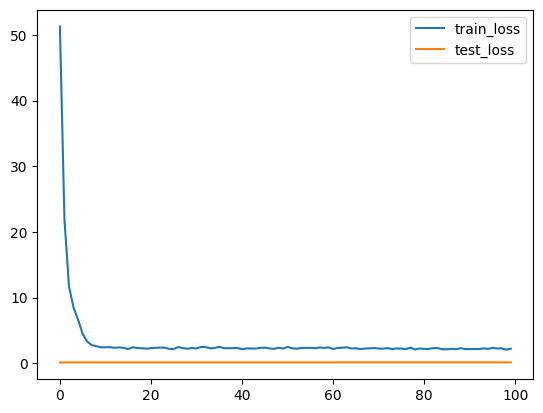

In [11]:

results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])